# NOT WORKING

## From raw

In [42]:
import pandas as pd

DATA_RAW_PATH = "data/raw/"
MURIEL_RAW = DATA_RAW_PATH+"muriel/"
MARIANNE_RAW = DATA_RAW_PATH+"marianne/"
CORA_RAW = DATA_RAW_PATH+"cora/"
JUL_SEV_RAW = DATA_RAW_PATH+"07-07/"
JUL_EI_RAW = DATA_RAW_PATH+"07-08/"
JUL_THI_RAW = DATA_RAW_PATH+"07-13/"

drive_raw_map = {   1:  (MURIEL_RAW+"t_003.tsv",(37,40)),
                    2:  (MURIEL_RAW+"t_003.tsv",(58,64)),
                    3:  (MURIEL_RAW+"t_003.tsv",(73,76)),
                    4:  (MURIEL_RAW+"t_004.tsv",(13,16)),
                    5:  (MARIANNE_RAW+"t_002.tsv",(36.3,41.5)),
                    6:  (MARIANNE_RAW+"t_002.tsv",(44.4,50)),
                    7:  (MARIANNE_RAW+"t_003.tsv",(3,8.9)),
                    8:  (MARIANNE_RAW+"t_005.tsv",(4,9)),
                    9:  (MARIANNE_RAW+"t_005.tsv",(9.2,13.4)),
                    10: (MARIANNE_RAW+"t_012.tsv",(14,20.1)),
                    11: (CORA_RAW+"t_028.tsv",(4.7,8.3)),
                    12: (CORA_RAW+"t_028.tsv",(12.8,18.5)),
                    13: (CORA_RAW+"t_028.tsv",(24.2,29.7)),
                    14: (CORA_RAW+"t_028.tsv",(29.8,36.2)),
                    15: (CORA_RAW+"t_028.tsv",(51.1,55)),
                    16: (CORA_RAW+"t_028.tsv",(57.9,63.8)),
                    17: (JUL_SEV_RAW+"t_051.tsv",(16.9,18.7)),
                    18: (JUL_SEV_RAW+"t_052.tsv",(11.5,13.2)),
                    19: (JUL_SEV_RAW+"t_052.tsv",(15,18)),
                    20: (JUL_SEV_RAW+"t_052.tsv",(19,21.5)),
                    21: (JUL_SEV_RAW+"t_060.tsv",(2,5)),
                    22: (JUL_SEV_RAW+"t_061.tsv",(58,61)),
                    23: (JUL_SEV_RAW+"t_063.tsv",(25.5,28.5)),    
                    24: (JUL_SEV_RAW+"t_064.tsv",(2.5,5.5)),    
                    25: (JUL_EI_RAW+"t_052.tsv",(8.1,11.8)),    # A   
                    26: (JUL_EI_RAW+"t_052.tsv",(11.8,15.1)),   # B   
                    27: (JUL_EI_RAW+"t_052.tsv",(12.15,14.7)),  # A         
                    28: (JUL_EI_RAW+"t_052.tsv",(8.5,11.8)),    # B       
                    29: (JUL_EI_RAW+"t_053.tsv",(22,24.5)),     # A  
                    30: (JUL_EI_RAW+"t_053.tsv",(22,24.5)),     # B      
                    31: (JUL_EI_RAW+"t_053.tsv",(25,27.2)),     # A     
                    32: (JUL_EI_RAW+"t_053.tsv",(25,27.2)),     # B   
                    33: (JUL_THI_RAW+"t_061.tsv",(29,32.1)), # A      
                    34: (JUL_THI_RAW+"t_061.tsv",(29,32.1)), # B       
                    35: (JUL_THI_RAW+"t_061.tsv",(74,80)),   # A 
                    36: (JUL_THI_RAW+"t_061.tsv",(74,80))    # B      
                    }


data = pd.read_csv(drive_raw_map[1][0], sep='\t',skiprows=10,low_memory=False)
data.head()

,Frame,Time,SMPTE,ARIEL X,ARIEL Y,ARIEL Z,LFHD X,LFHD Y,LFHD Z,RFHD X,...,RBHD X,RBHD Y,RBHD Z,LBHD X,LBHD Y,LBHD Z,LPLM X,LPLM Y,LPLM Z,Unnamed: 189
0,1,0.00000,00:34:38.17:01,915.832,1636.494,-102.556,860.323,1594.619,-35.402,877.048,...,978.740,1481.155,-155.687,975.891,1501.635,-14.070,962.765,1354.705,679.482,NaN
1,2,0.01042,00:34:38.17:02,915.833,1636.502,-102.572,860.359,1594.634,-35.406,877.051,...,978.740,1481.176,-155.698,975.945,1501.673,-14.085,962.826,1354.702,679.471,NaN
2,3,0.02083,00:34:38.17:03,915.849,1636.510,-102.606,860.385,1594.632,-35.414,877.072,...,978.776,1481.168,-155.703,975.970,1501.698,-14.092,962.879,1354.709,679.464,NaN
3,4,0.03125,00:34:38.18:00,915.765,1636.592,-102.680,860.628,1594.947,-35.348,877.593,...,979.312,1480.932,-155.603,976.193,1502.154,-14.207,962.849,1354.905,679.555,NaN
4,5,0.04167,00:34:38.18:01,915.807,1636.588,-102.680,860.487,1594.766,-35.691,877.511,...,979.331,1480.824,-155.588,976.034,1502.055,-14.083,962.898,1354.968,679.470,NaN


In [43]:
data = data.iloc[:,3:]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14770 entries, 0 to 14769
Columns: 187 entries, ARIEL X to Unnamed: 189
dtypes: float64(130), object(57)
memory usage: 21.1+ MB


## From processed split
BAD LOOKING SHAPES...

In [44]:
import pandas as pd

DATA_PROCESSED_PATH = "data/processed/"
MURIEL_PROCESSED = DATA_PROCESSED_PATH+"muriel/"
MARIANNE_PROCESSED = DATA_PROCESSED_PATH+"marianne/"
CORA_PROCESSED = DATA_PROCESSED_PATH+"cora/"
JUL_SEV_PROCESSED = DATA_PROCESSED_PATH+"07-07/"
JUL_EI_PROCESSED = DATA_PROCESSED_PATH+"07-08/"
JUL_THI_PROCESSED = DATA_PROCESSED_PATH+"07-13/"

drive_processed_map = { 1:  (MURIEL_PROCESSED+"t_003/t_003",(37,40)),
                        2:  (MURIEL_PROCESSED+"t_003/t_003",(58,64)),
                        3:  (MURIEL_PROCESSED+"t_003/t_003",(73,76)),
                        4:  (MURIEL_PROCESSED+"t_004/t_004",(13,16)),
                        5:  (MARIANNE_PROCESSED+"t_002/t_002",(36.3,41.5)),
                        6:  (MARIANNE_PROCESSED+"t_002/t_002",(44.4,50)),
                        7:  (MARIANNE_PROCESSED+"t_003/t_003",(3,8.9)),
                        8:  (MARIANNE_PROCESSED+"t_005/t_005",(4,9)),
                        9:  (MARIANNE_PROCESSED+"t_005/t_005",(9.2,13.4)),
                        10: (MARIANNE_PROCESSED+"t_012/t_012",(14,20.1)),
                        11: (CORA_PROCESSED+"t_028",(4.7,8.3)),
                        12: (CORA_PROCESSED+"t_028",(12.8,18.5)),
                        13: (CORA_PROCESSED+"t_028",(24.2,29.7)),
                        14: (CORA_PROCESSED+"t_028",(29.8,36.2)),
                        15: (CORA_PROCESSED+"t_028",(51.1,55)),
                        16: (CORA_PROCESSED+"t_028",(57.9,63.8)),
                        17: (JUL_SEV_PROCESSED+"t_051/t_051",(16.9,18.7)),
                        18: (JUL_SEV_PROCESSED+"t_052/t_052",(11.5,13.2)),
                        19: (JUL_SEV_PROCESSED+"t_052/t_052",(15,18)),
                        20: (JUL_SEV_PROCESSED+"t_052/t_052",(19,21.5)),
                        21: (JUL_SEV_PROCESSED+"t_060/t_060",(2,5)),
                        22: (JUL_SEV_PROCESSED+"t_061/t_061",(58,61)),
                        23: (JUL_SEV_PROCESSED+"t_063/t_063",(25.5,28.5)),
                        24: (JUL_SEV_PROCESSED+"t_064/t_064",(2.5,5.5)),
                        25: (JUL_EI_PROCESSED+"t_052/A/t_052_A",(8.1,11.8)),       
                        26: (JUL_EI_PROCESSED+"t_052/B/t_052_B",(11.8,15.1)),      
                        27: (JUL_EI_PROCESSED+"t_052/A/t_052_A",(12.15,14.7)),     
                        28: (JUL_EI_PROCESSED+"t_052/B/t_052_B",(8.5,11.8)),       
                        29: (JUL_EI_PROCESSED+"t_053/A/t_053_A",(22,24.5)),
                        30: (JUL_EI_PROCESSED+"t_053/B/t_053_B",(22,24.5)),        
                        31: (JUL_EI_PROCESSED+"t_053/A/t_053_A",(25,27.2)),        
                        32: (JUL_EI_PROCESSED+"t_053/B/t_053_B",(25,27.2)),        
                        33: (JUL_THI_PROCESSED+"t_061/A/t_061_A",(29,32.1)),       
                        34: (JUL_THI_PROCESSED+"t_061/B/t_061_B",(29,32.1)),        
                        35: (JUL_THI_PROCESSED+"t_061/A/t_061_A",(74,80)),
                        36: (JUL_THI_PROCESSED+"t_061/B/t_061_B",(74,80))         
                    }


tableX = pd.DataFrame()
tableY = pd.DataFrame()
tableZ = pd.DataFrame()

dtypes = {'X': float, 'Y': float, 'Z': float}

for i in range(1,21):
    data = pd.read_csv(drive_processed_map[1][0]+"_split_"+str(i)+"_out.txt",skiprows=1,sep=',',header=None,dtype=dtypes)
    tableX = pd.concat([tableX,data[0]],axis=1)
    tableY = pd.concat([tableY,data[1]],axis=1)
    tableZ = pd.concat([tableZ,data[2]],axis=1)
tableX.head()
#table = data
print(tableX.info())
print(tableY.info())
print(tableZ.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14770 entries, 0 to 14769
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       14770 non-null  float64
 1   0       14770 non-null  float64
 2   0       14770 non-null  float64
 3   0       14770 non-null  float64
 4   0       14770 non-null  float64
 5   0       14770 non-null  float64
 6   0       14770 non-null  float64
 7   0       14770 non-null  float64
 8   0       14770 non-null  float64
 9   0       14770 non-null  float64
 10  0       14770 non-null  float64
 11  0       14770 non-null  float64
 12  0       14770 non-null  float64
 13  0       14770 non-null  float64
 14  0       14770 non-null  float64
 15  0       14770 non-null  float64
 16  0       14770 non-null  float64
 17  0       14770 non-null  float64
 18  0       14770 non-null  float64
 19  0       14770 non-null  float64
dtypes: float64(20)
memory usage: 2.3 MB
None
<class 'pandas.core.frame.DataF

In [45]:
from matplotlib import pyplot as plt
%matplotlib
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#tableNoTime = table.iloc[:,1:]
#timeCol = table.iloc[:,0]
#if needRotation:
#    tableX = tableNoTime.iloc[:,::3]
#    tableZ = tableNoTime.iloc[:,1::3]
#    tableY = tableNoTime.iloc[:,2::3]
#else:
#    tableX = tableNoTime.iloc[:,::3]
#    tableY = tableNoTime.iloc[:,1::3]
#    tableZ = tableNoTime.iloc[:,2::3]

#theta = np.pi/2  # 90 degrees in radians
#R = np.array([[np.cos(theta), -np.sin(theta), 0],
#              [np.sin(theta), np.cos(theta), 0],
#              [0, 0, 1]])
#
#for i in range(len(tableX)):
#    # Apply the rotation matrix to the data
#    data_st = np.vstack([tableX[i,:], tableY[i,:], tableZ[i,:]])
#    data_rotated = np.dot(data_st, R)
#    tableX[i,:]=data_rotated[0,:]
#    tableY[i,:]=data_rotated[1,:]
#    tableZ[i,:]=data_rotated[2,:]    
#tableX = data_rotated[:,0]
#tableY = data_rotated[:,1]
#tableZ = data_rotated[:,2]

minMax = np.zeros((2,3))
minMax[0,:] = [tableX.values.min(),tableY.values.min(),tableZ.values.min()]
minMax[1,:] = [tableX.values.max(),tableY.values.max(),tableZ.values.max()]

print(minMax)

# Set appropriate axis limits
ax.set_xlim([minMax[0,0],minMax[1,0]])
ax.set_ylim([minMax[0,1],minMax[1,1]])
ax.set_zlim([minMax[0,2],minMax[1,2]])

# Set the initial time index
time_index = 0

# Function to update the plot based on the slider value
def update_plot(val):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = tableX.iloc[val]
    filteredY = tableY.iloc[val]
    filteredZ = tableZ.iloc[val]
    
    ax.scatter(filteredX,filteredY,filteredZ)

    ax.set_xlim([minMax[0,0],minMax[1,0]])
    ax.set_ylim([minMax[0,1],minMax[1,1]])
    ax.set_zlim([minMax[0,2],minMax[1,2]])
    
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title('3D Movement')

    fig.canvas.draw_idle()

# Create a slider widget
slider_ax = plt.axes([0.2, 0.03, 0.6, 0.03])
slider = Slider(slider_ax, 'TimeIndex', 0, tableX.shape[0]-1, valinit=time_index, valstep=1)

# Register the update_plot function with the slider widget
slider.on_changed(update_plot)

# Initial plot
update_plot(time_index)

# Show the plot
plt.show()


Using matplotlib backend: TkAgg
[[-0.09629714 -0.0039084  -0.89798571]
 [ 1.69142434  2.0124404   2.4209322 ]]


## From processed
Are these speed and acceleration values? why are they 20 cols and not 60 (20 markers x 3 dims) ? Are these magnitudes?

In [46]:
# Questo non ha senso
DATA_POSITION_PATH = "data/derivated_orig/07-07/t_051/t_051_ACCELERATION.txt"
table = pd.read_table(DATA_POSITION_PATH,header=None,sep=' ')
#needRotation = True
table.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.00,0.003027,0.001672,0.000601,-0.000017,-0.000013,0.000750,0.002242,0.004252,0.006413,...,-0.002697,-0.002618,-0.001668,-0.000226,0.001307,0.002535,0.003224,0.003379,0.003112,0.002578
1,0.01,0.005455,0.003104,0.001259,0.000219,0.000280,0.001689,0.004388,0.007996,0.011840,...,-0.005426,-0.005077,-0.003000,0.000119,0.003537,0.006486,0.008437,0.009250,0.009030,0.008120
2,0.02,0.008882,0.005397,0.002703,0.001269,0.001563,0.003981,0.008426,0.014264,0.020360,...,-0.010984,-0.009786,-0.005258,0.001468,0.009127,0.016302,0.021794,0.024903,0.025494,0.024317
3,0.03,0.009054,0.006258,0.004175,0.003249,0.003956,0.006689,0.011337,0.017215,0.023078,...,-0.016168,-0.013854,-0.007000,0.003156,0.015157,0.027187,0.037351,0.044079,0.046711,0.046378
4,0.04,0.005969,0.005397,0.005106,0.005333,0.006409,0.008588,0.011757,0.015389,0.018543,...,-0.019358,-0.016389,-0.008284,0.003837,0.018590,0.034063,0.047932,0.057983,0.063147,0.064739


# WORKING

## Reading data from cleaned

```
TODO Manca muriel t_006 and t_008
Bisogna pulire ulteriormente i dati perchè il lavoro sembra non essere stato fatto bene (PI potrebbe impattare, I impatta, NI non impatta, R risolvibile, NR non risolvibile):
    - 3 PI | NR
    - 5 I | R
    - 7 I | R (la joint va fixata sul tricipite ma viene misinterpretata come una mano)
    - 8 I | R
    - 9 I | R (potrebbe essere complicato)
    - 13 PI ? | R : è ruotato di 45 gradi e potrebbe overfittare sul disallineamento trovando correlazione spuria per le etichette dei movimenti bassi del corpo (cora t_0028_3)
    - 14 stesso di 13 e sempre movimenti di gambe
    - 17 NI | R testa disallineata
    - 18 come 17 e potrebbe essere utile mappare la camminata come non OoM in entrambe le direzioni, ora son riuscito solo a farlo andare da sinistra a destra e ruotato come in direzione entrante
    - 19/20/21/22/23/24/25/26/27/28/29/30/31 come 17
    - da 25 i dispari sono specchiati e dovrebbero essere girati frontali
    - 27 I | R due joints nelle ginocchia e la spalla sinistra vanno fuori, ci vuole una constraint che faccia da interpolazione sulla distanza dalle due adiacenti
    - 33 I | R (?) ginocchio e pezzi di braccia volano via
    - 34 I | R gomito da lontano si riavvicina
    - 35 I | Difficilmente risolvibile, molto complesso... vanno via un sacco di cose

[ Probabilmente la strada migliore consiste nel prendere il 97.5% della coda destra di velocità e accelerazione per gran parte di questi e sostituire con la media di velocità e accelerazione le giunture limitrofe a quelle che stanno sopra la soglia
Ma bisogna prima metterle su dei grafici per controllare di non star tagliando fuori parti importanti 
Alternativa è riposizionare le anomalie con la regola 97.5% (o più) e calcolare le velocità in un secondo momento ] TODO se c'è tempo
```

In [2]:
import pandas as pd

DATA_POSITION_PATH = "data/position/"
DATA_DERIVATED_PATH = "data/derivated/"
MURIEL_POS = DATA_POSITION_PATH+"muriel/"
MARIANNE_POS = DATA_POSITION_PATH+"marianne/"
CORA_POS = DATA_POSITION_PATH+"cora/"
JUL_SEV_POS = DATA_POSITION_PATH+"07-07/"
JUL_EI_POS = DATA_POSITION_PATH+"07-08/"
JUL_THI_POS = DATA_POSITION_PATH+"07-13/"

# mappings are index -> (file_path, start_end_segment_tuple) in seconds
# TODO movements directions must be set consistently but in trials 1 -> 24 are in a way, while 25 to 36 are flipped, must set everything frontal
# TODO distibution of position should be normalized (maybe)
drivePosMap = { 1:  (MURIEL_POS+"t_003_finalclean.tsv",(37,40.5)),        
                2:  (MURIEL_POS+"t_003_finalclean.tsv",(58,64)),        
                3:  (MURIEL_POS+"t_003_finalclean.tsv",(73,76)),
                4:  (MURIEL_POS+"t_004_finalclean.tsv",(13,16)),
                5:  (MARIANNE_POS+"t_002_finalclean.tsv",(36.3,41.5)),
                6:  (MARIANNE_POS+"t_002_finalclean.tsv",(44.4,50)),
                7:  (MARIANNE_POS+"t_003_finalclean.tsv",(3,8.9)),
                8:  (MARIANNE_POS+"t_005_finalclean.tsv",(4,9)),
                9:  (MARIANNE_POS+"t_005_finalclean.tsv",(9.2,13.4)),
                10: (MARIANNE_POS+"t_012_finalclean.tsv",(14,20.1)),
                11: (CORA_POS+"t_028_finalclean.tsv",(4.7,8.3)),
                12: (CORA_POS+"t_028_finalclean.tsv",(12.8,18.5)),
                13: (CORA_POS+"t_028_finalclean.tsv",(24.2,29.7)),
                14: (CORA_POS+"t_028_finalclean.tsv",(29.8,36.2)),
                15: (CORA_POS+"t_028_finalclean.tsv",(51.1,55)),
                16: (CORA_POS+"t_028_finalclean.tsv",(57.9,63.8)),
                17: (JUL_SEV_POS+"t_051_finalclean.tsv",(16.9,18.7)),
                18: (JUL_SEV_POS+"t_052_finalclean.tsv",(11.5,13.2)),
                19: (JUL_SEV_POS+"t_052_finalclean.tsv",(15,18)),
                20: (JUL_SEV_POS+"t_052_finalclean.tsv",(19,21.5)),
                21: (JUL_SEV_POS+"t_060_finalclean.tsv",(2.6,5)),
                22: (JUL_SEV_POS+"t_061_finalclean.tsv",(58,61)),
                23: (JUL_SEV_POS+"t_063_finalclean.tsv",(25.5,28.5)),
                24: (JUL_SEV_POS+"t_064_finalclean.tsv",(2.5,5.5)),
                
                # TODO all these following have a problem with the head position and many with some joints going crazy
                # A_B trials maybe should be turned in front instead of on a side for consistency
                25: (JUL_EI_POS+"t_052_A_finalclean.tsv",(8.1,11.8)),       # ball catch left side
                26: (JUL_EI_POS+"t_052_B_finalclean.tsv",(11.8,15.1)),      # ball catch right side
                27: (JUL_EI_POS+"t_052_A_finalclean.tsv",(12.15,14.7)),     # ball throw left side
                28: (JUL_EI_POS+"t_052_B_finalclean.tsv",(8.5,11.8)),       # ball throw right side
                29: (JUL_EI_POS+"t_053_A_finalclean.tsv",(22,24.5)),        # ball high throw left side
                30: (JUL_EI_POS+"t_053_B_finalclean.tsv",(22,24.5)),        # ball side catch right side
                31: (JUL_EI_POS+"t_053_A_finalclean.tsv",(25,27.2)),        # ball throw left side
                32: (JUL_EI_POS+"t_053_B_finalclean.tsv",(25,27.2)),        # ball catch right side
                33: (JUL_THI_POS+"t_061_A_finalclean.tsv",(29,32.1)),       # ball throw cheat left side
                34: (JUL_THI_POS+"t_061_B_finalclean.tsv",(29,32.1)),       # ball catch right side TODO error in joint 
                35: (JUL_THI_POS+"t_061_A_finalclean.tsv",(74,80)),         # right ball catch left side TODO many joints going crazy
                36: (JUL_THI_POS+"t_061_B_finalclean.tsv",(74,80))          # ball catch right side
              }

picked = 1

data = drivePosMap[picked]
table = pd.read_table(data[0])
table.head()

,Time,left_foot_X,left_foot_Y,left_foot_Z,right_foot_X,right_foot_Y,right_foot_Z,left_ankle_X,left_ankle_Y,left_ankle_Z,...,left_shoulder_Z,shoulder_center_X,shoulder_center_Y,shoulder_center_Z,right_shoulder_X,right_shoulder_Y,right_shoulder_Z,head_X,head_Y,head_Z
0,0.00000,0.880078,0.005587,0.003165,0.890875,0.003183,-0.219213,0.955926,0.076895,0.035329,...,0.051810,0.951091,1.354649,-0.089303,0.971931,1.351419,-0.230416,0.921563,1.560234,-0.094183
1,0.01042,0.880026,0.005624,0.003019,0.890553,0.003508,-0.219397,0.955918,0.076906,0.035318,...,0.051775,0.951122,1.354691,-0.089327,0.971946,1.351445,-0.230429,0.921630,1.560252,-0.094193
2,0.02083,0.879969,0.005662,0.002873,0.890258,0.003751,-0.219501,0.955908,0.076915,0.035303,...,0.051740,0.951150,1.354736,-0.089351,0.971961,1.351480,-0.230442,0.921697,1.560268,-0.094201
3,0.03125,0.879907,0.005704,0.002734,0.890010,0.003858,-0.219486,0.955896,0.076923,0.035283,...,0.051706,0.951176,1.354786,-0.089374,0.971978,1.351534,-0.230453,0.921759,1.560279,-0.094205
4,0.04167,0.879844,0.005746,0.002612,0.889819,0.003826,-0.219372,0.955884,0.076930,0.035259,...,0.051673,0.951200,1.354842,-0.089396,0.971996,1.351612,-0.230465,0.921815,1.560285,-0.094202


In [3]:
startEndSeconds = data[1]
posTable = table[table["Time"].between(startEndSeconds[0],startEndSeconds[1])].iloc[:,1:]
    

if 1 <= picked <= 10:
    posTableY = posTable.iloc[:,::3]
    posTableZ = posTable.iloc[:,1::3]
    posTableX = posTable.iloc[:,2::3]
elif 11 <= picked <= 16:
    posTableX = posTable.iloc[:,::3]
    posTableZ = posTable.iloc[:,1::3]
    posTableY = posTable.iloc[:,2::3]
elif (17 <= picked <= 20 and picked != 19) or picked >= 25:
    posTableY = posTable.iloc[:,::3]
    posTableX = posTable.iloc[:,1::3]
    posTableZ = posTable.iloc[:,2::3]
else:
    posTableX = posTable.iloc[:,::3]
    posTableY = posTable.iloc[:,1::3]
    posTableZ = posTable.iloc[:,2::3]

posTableX = posTableX.rename(columns=dict(zip(list(posTableX),[name.replace('Z','X').replace('Y','X') for name in list(posTableX)])))
posTableY = posTableY.rename(columns=dict(zip(list(posTableY),[name.replace('Z','Y').replace('X','Y') for name in list(posTableY)])))
posTableZ = posTableZ.rename(columns=dict(zip(list(posTableZ),[name.replace('X','Z').replace('Y','Z') for name in list(posTableZ)])))

#theta = np.pi/2  # 90 degrees in radians
#R = np.array([[np.cos(theta), -np.sin(theta), 0],
#              [np.sin(theta), np.cos(theta), 0],
#              [0, 0, 1]])

#for i in range(len(tableX)):
#    # Apply the rotation matrix to the data
#    data_st = np.vstack([tableX.iloc[i,:], tableY.iloc[i,:], tableZ.iloc[i,:]])
#    data_rotated = np.dot(data_st, R)
#    tableX[i,:]=data_rotated[0,:]
#    tableY[i,:]=data_rotated[1,:]
#    tableZ[i,:]=data_rotated[2,:]    
#tableX = data_rotated[:,0]
#tableY = data_rotated[:,1]
#tableZ = data_rotated[:,2]

In [4]:
from matplotlib import pyplot as plt
%matplotlib
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


minMax = np.zeros((2,3))
minMax[0,:] = [posTableX.values.min(),posTableY.values.min(),posTableZ.values.min()]
minMax[1,:] = [posTableX.values.max(),posTableY.values.max(),posTableZ.values.max()]

print(minMax)

# Set appropriate axis limits
ax.set_xlim([minMax[0,0],minMax[1,0]])
ax.set_ylim([minMax[0,1],minMax[1,1]])
ax.set_zlim([minMax[0,2],minMax[1,2]])

# Set the window title
fig.canvas.manager.window.title("3D Movement\t(Scroll with mouse wheel)")

# Set the initial time index
time_index = 0

# Function to update the plot based on the slider value
def update_plot(val):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = posTableX.iloc[val]
    filteredY = posTableY.iloc[val]
    filteredZ = posTableZ.iloc[val]
    
    ax.scatter(filteredX,filteredY,filteredZ)

    ax.set_xlim([minMax[0,0],minMax[1,0]])
    ax.set_ylim([minMax[0,1],minMax[1,1]])
    ax.set_zlim([minMax[0,2],minMax[1,2]])
    
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title("Movement "+str(picked))

    fig.canvas.draw_idle()

# Create a slider widget
slider_ax = plt.axes([0.2, 0.03, 0.6, 0.03])
maxValue = posTable.shape[0]-1
slider = Slider(slider_ax, 'TimeIndex:', 0, maxValue, valinit=time_index, valstep=1)


# Define a function to update the slider value with the mouse wheel
def on_scroll(event):
    if event.button == 'down':
        if slider.val + slider.valstep*5 <= maxValue:
            slider.set_val(slider.val + slider.valstep*2)
    elif event.button == 'up':
        if slider.val - slider.valstep*10 >= 0:
            slider.set_val(slider.val - slider.valstep*2)
        

# Connect the mouse wheel event to the function
fig.canvas.mpl_connect('scroll_event', on_scroll)


# Register the update_plot function with the slider widget
slider.on_changed(update_plot)

# Initial plot
update_plot(time_index)

# Show the plot
plt.show()


Using matplotlib backend: <object object at 0x7fbc62b57e50>
[[-0.78655715 -0.00617931  0.00219524]
 [ 0.57748145  1.45234593  2.0124404 ]]


## Calculating Angular Momentum

In [5]:
jointNames = [  'left_foot',
                'right_foot',
                'left_ankle',
                'right_ankle',
                'left_knee',
                'right_knee',
                'left_hip',
                'hip_center',
                'right_hip', 
                'spine',
                'left_hand',
                'right_hand',
                'left_wrist',
                'right_wrist',
                'left_elbow',
                'right_elbow',
                'left_shoulder',
                'shoulder_center',
                'right_shoulder',
                'head'  ]

In [6]:
m_lfoot = 0.0145;m_rfoot = 0.0145;m_lank = 0.0465;m_rank = 0.0465
m_lknee = 0.1;m_rknee = 0.1;m_lhip = 0.1;m_hipc = 0.139;m_rhip = 0.1
m_spine = 0.216;m_lhand = 0.006;m_rhand = 0.006;m_lwrist = 0.016;m_rwrist = 0.016
m_lelb = 0.028;m_relb = 0.028;m_lsho = 0.0158;m_shoc = 0.081;m_rsho = 0.0158;m_head = 0.081

mass = [m_lfoot,
        m_rfoot, 
        m_lank,
        m_rank,
        m_lknee, 
        m_rknee, 
        m_lhip,
        m_hipc,
        m_rhip,
        m_spine,
        m_lhand,
        m_rhand,
        m_lwrist,
        m_rwrist,
        m_lelb,
        m_relb,
        m_lsho,
        m_shoc,
        m_rsho,
        m_head  ]
mass3D = np.repeat(mass,3)

In [7]:
def merge_tables(xTable,yTable,zTable):
    mergedTable = pd.DataFrame()
    for j in range(xTable.shape[1]):
        mergedTable = pd.concat([mergedTable,xTable.iloc[:,j],yTable.iloc[:,j],zTable.iloc[:,j]],axis=1)
    return mergedTable

def split_table(table,into="xyz"):
    if into == "xyz":
        return table.iloc[:,::3],table.iloc[:,1::3],table.iloc[:,2::3]
    elif into == "points":
        return [table.iloc[:,j:j+3] for j in range(0,table.shape[1],3)]

In [8]:
centerOfMassX = posTableX.dot(mass).div(sum(mass))
centerOfMassY = posTableY.dot(mass).div(sum(mass))
centerOfMassZ = posTableZ.dot(mass).div(sum(mass))

radiusQX = posTableX.sub(centerOfMassX,axis=0)
radiusQY = posTableY.sub(centerOfMassY,axis=0)
radiusQZ = posTableZ.sub(centerOfMassZ,axis=0)

radiusQTable = merge_tables(radiusQX,radiusQY,radiusQZ)
timeCol = table[table["Time"].between(startEndSeconds[0],startEndSeconds[1])]["Time"]
velocityTable = pd.DataFrame(np.gradient(posTable,timeCol,axis=0),columns=[f'{c}' for c in posTable.columns])
p = velocityTable.mul(mass3D)
p = [point.to_numpy() for point in split_table(p,into="points")]
r = [point.to_numpy() for point in split_table(radiusQTable, into="points")]
l = np.cross(p,r)

angularMomentumTable = radiusQTable*0
for j,point in enumerate(l):
    for i in range(len(point)):
        angularMomentumTable.iloc[i,3*j:3*j+3] = point[i]
angularMomentumTable.head()

,left_foot_X,left_foot_Y,left_foot_Z,right_foot_X,right_foot_Y,right_foot_Z,left_ankle_X,left_ankle_Y,left_ankle_Z,right_ankle_X,...,left_shoulder_Z,shoulder_center_X,shoulder_center_Y,shoulder_center_Z,right_shoulder_X,right_shoulder_Y,right_shoulder_Z,head_X,head_Y,head_Z
3552,-8.481859e-08,-0.000002,1.288280e-07,-4.990366e-07,1.018480e-06,1.268165e-08,0.000009,-0.000054,7.135355e-07,0.000198,...,-0.000021,0.000260,0.000691,0.000044,0.000055,0.000279,0.000037,-0.000133,0.000106,0.000003
3553,-8.928879e-08,-0.000002,1.039464e-07,-6.971826e-07,9.501523e-07,4.568127e-08,0.000010,-0.000055,8.275951e-07,0.000209,...,-0.000021,0.000259,0.000704,0.000045,0.000055,0.000284,0.000037,-0.000129,0.000092,0.000002
3554,-1.782143e-07,-0.000001,5.943020e-08,-1.020653e-06,6.242300e-07,1.120537e-07,0.000011,-0.000057,9.706263e-07,0.000227,...,-0.000020,0.000258,0.000728,0.000047,0.000056,0.000294,0.000038,-0.000121,0.000069,0.000002
3555,-3.601246e-07,-0.000001,3.328653e-08,-1.111757e-06,1.507145e-08,1.611017e-07,0.000012,-0.000060,1.016623e-06,0.000237,...,-0.000021,0.000262,0.000748,0.000049,0.000057,0.000302,0.000039,-0.000110,0.000051,0.000002
3556,-4.814908e-07,-0.000001,3.863321e-08,-8.563568e-07,-6.881588e-07,1.650597e-07,0.000012,-0.000062,1.084644e-06,0.000238,...,-0.000021,0.000274,0.000770,0.000050,0.000060,0.000312,0.000041,-0.000099,0.000037,0.000002


## Calculating cosine similarity between every adjacent joint
![bodymarkersCosine](../resources/bodymarkersForCosine.png)

In [9]:
from scipy.spatial.distance import cosine
def compute_cosine_similarity_on_joints(table,normalized:None or int=None):
    jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
    jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]

    jointsFrom = list(map(lambda x: x-1,jointsFrom))
    jointsTo = list(map(lambda x: x-1,jointsTo))

    cosineSim = pd.DataFrame()
    columnNames = list(table.columns)
    for jointFrom,jointTo in zip(jointsFrom,jointsTo):
        cosineSim[columnNames[jointFrom]+" - "+columnNames[jointTo]] = table.apply(lambda row: 2 - cosine(row[columnNames[jointFrom]],row[columnNames[jointTo]]),axis=1)
    return cosineSim if normalized is None else cosineSim.div(cosineSim.max(axis=1))*normalized

def group_table_by_joints(table):
    columns = [col.replace('_X','') for col in list(table.columns)[::3]]
    result = pd.DataFrame(columns=columns)
    for j in range(0,table.shape[1],3):
        lst = []
        for i in range(table.shape[0]):
            lst.append(table.iloc[i,j:j+3].values)
        result[columns[int(j/3)]] = lst
    return result

### For angular momentum

In [10]:
angularMomentumGroupedTable = group_table_by_joints(angularMomentumTable)
angularMomentumGroupedTable.head()

,left_foot,right_foot,left_ankle,right_ankle,left_knee,right_knee,left_hip,hip_center,right_hip,spine,left_hand,right_hand,left_wrist,right_wrist,left_elbow,right_elbow,left_shoulder,shoulder_center,right_shoulder,head
0,"[-8.481858671770431e-08, -1.910949224495498e-0...","[-4.990365756585407e-07, 1.018480369309418e-06...","[9.386049570138977e-06, -5.359602458867138e-05...","[0.00019810388924009544, -9.088540060542302e-0...","[3.217748379026128e-05, -0.0001587249282897077...","[-2.353230406906948e-05, -0.000169639394177491...","[-2.8774691369438332e-05, -9.855942763861555e-...","[2.826475093963874e-05, 5.5032585571385486e-05...","[5.5342555588210434e-05, 9.62633682237234e-06,...","[0.00015078558222081986, 0.0005031829833269711...","[9.68626964197699e-06, 7.600264667906586e-05, ...","[-1.787719635740477e-05, -0.000129668977792091...","[6.321645595283168e-06, 0.00011281142627325937...","[6.153062411042985e-07, -0.0001838650685236392...","[6.155135787992385e-07, -0.0002730567565029008...","[1.783651800905553e-05, 0.0003147950444154029,...","[4.630728504330599e-05, -2.988330514329956e-06...","[0.0002598222045839961, 0.0006908105508023496,...","[5.519126385887507e-05, 0.00027861228965409023...","[-0.00013284616701182917, 0.000105813964511418..."
1,"[-8.928878908410463e-08, -1.5804297414048952e-...","[-6.971825953142204e-07, 9.501522663083293e-07...","[1.016367179739023e-05, -5.454645212163889e-05...","[0.00020942397802558956, -8.93544102681796e-05...","[3.075332328919849e-05, -0.0001543840595577321...","[-3.964136225588645e-05, -0.000183634058601283...","[-3.4780405018151594e-05, -0.00013385546205527...","[2.560609720172637e-05, 4.402216598306766e-05,...","[5.572611890082674e-05, 1.0324042639569059e-05...","[0.00016437405924825226, 0.0004870718747920191...","[9.265445649555465e-06, 7.438452470047178e-05,...","[-1.6805270008873488e-05, -0.00013643058817148...","[6.618602833056094e-06, 0.0001136428448291735,...","[2.53315888696722e-06, -0.00019786035657458752...","[2.507092198207407e-07, -0.0002733265426462690...","[1.6841696091995663e-05, 0.0003235645698483272...","[4.5818749695650985e-05, -3.324931835249495e-0...","[0.0002588409233950583, 0.0007041015195700927,...","[5.529698899187842e-05, 0.0002838908701528798,...","[-0.00012920402776149076, 9.216925768922847e-0..."
2,"[-1.7821426138501256e-07, -1.1269168442169807e...","[-1.0206528258265662e-06, 6.242300203093699e-0...","[1.1236163787542125e-05, -5.6794769772511547e-...","[0.0002267185890661297, -5.8720704441184e-05, ...","[2.6045238476386617e-05, -0.000141285077274661...","[-6.288079818853932e-05, -0.000193705022158437...","[-4.615985902188415e-05, -0.000197069668155862...","[2.044771613598332e-05, 2.526625722946964e-05,...","[5.663306789158135e-05, 1.4098543947612375e-05...","[0.00019199582999766666, 0.0004464486577189576...","[8.623407956499367e-06, 7.086383875414393e-05,...","[-1.4536947899726228e-05, -0.00014983052067495...","[7.168575709524849e-06, 0.00011497159760302777...","[6.557977843770893e-06, -0.0002271215308131915...","[-7.419165493662344e-07, -0.000274050573408230...","[1.467283192728132e-05, 0.00034082327176491355...","[4.5164677368620047e-05, -3.928459210124352e-0...","[0.0002581340489852437, 0.0007278115766093817,...","[5.5683710731205255e-05, 0.0002935276086215660...","[-0.00012057330246149072, 6.850523608907353e-0..."
3,"[-3.601245568080253e-07, -1.0872889886051335e-...","[-1.1117565523044768e-06, 1.5071449276558696e-...","[1.1799698263465517e-05, -5.952297683446257e-0...","[0.00023661004450496758, 3.065302451265209e-05...","[1.7957786972421597e-05, -0.000117403451956937...","[-6.660601654040779e-05, -0.000173761233940585...","[-5.378367239820457e-05, -0.000232753337600582...","[1.7176138408771602e-05, 1.7589483456544675e-0...","[5.8217190866700315e-05, 2.2019930083840803e-0...","[0.00022045299802646293, 0.0003968736211340009...","[8.33823661882569e-06, 6.704726280874646e-05, ...","[-1.2570633648972387e-05, -0.00016431334823468...","[7.559871526849583e-06, 0.00

In [11]:
cosineSimAngMom = compute_cosine_similarity_on_joints(angularMomentumGroupedTable)
cosineSimAngMom.head()

,left_foot - left_ankle,left_ankle - left_knee,left_knee - left_hip,left_hip - hip_center,right_foot - right_ankle,right_ankle - right_knee,right_knee - right_hip,right_hip - hip_center,hip_center - spine,spine - shoulder_center,left_hand - left_wrist,left_wrist - left_elbow,left_elbow - left_shoulder,left_shoulder - shoulder_center,right_hand - right_wrist,right_wrist - right_elbow,right_elbow - right_shoulder,right_shoulder - shoulder_center,shoulder_center - head
0,1.974982,1.998005,1.867363,0.050282,0.238708,1.273976,0.873173,1.614838,1.757515,1.932351,1.290687,0.138325,1.043046,1.240566,1.980999,0.088756,1.979167,1.984381,1.308084
1,1.969964,1.998430,1.872270,0.054361,0.149527,1.173610,0.845471,1.634475,1.760121,1.934679,1.293875,0.133832,1.046796,1.226784,1.982012,0.083552,1.978707,1.985130,1.264570
2,1.938099,1.998683,1.879449,0.100978,0.048260,0.924291,0.788530,1.690852,1.763976,1.934607,1.299609,0.125631,1.052034,1.203752,1.983962,0.071461,1.976854,1.986258,1.175532
3,1.870023,1.998112,1.893003,0.141055,0.010958,0.517827,0.721878,1.736606,1.782868,1.925847,1.302423,0.118518,1.055010,1.189604,1.985359,0.061912,1.973866,1.986716,1.097503
4,1.860286,1.994284,1.916462,0.072626,0.005659,0.197175,0.671270,1.749816,1.802500,1.907563,1.302378,0.112909,1.057768,1.184258,1.986108,0.056140,1.970011,1.986527,1.020014


### For speed

In [12]:
velocityGroupedTable = group_table_by_joints(velocityTable)
velocityGroupedTable.head()

,left_foot,right_foot,left_ankle,right_ankle,left_knee,right_knee,left_hip,hip_center,right_hip,spine,left_hand,right_hand,left_wrist,right_wrist,left_elbow,right_elbow,left_shoulder,shoulder_center,right_shoulder,head
0,"[-0.0001254673411550688, -9.268622245729396e-0...","[6.84105681252281e-05, 3.46442371976738e-05, -...","[-0.001415555515084548, -0.0002517353097207952...","[-0.001175580589655499, -0.00576144123575621, ...","[-0.003481523025714679, -0.0007169704127632261...","[-0.004022795775048698, 0.000522172573803472, ...","[0.00021713718906718948, 0.0009298940790016282...","[-0.004742270795854533, 0.002927280175145374, ...","[-0.009682346128310801, 0.004924181231769374, ...","[-0.00933841719863727, 0.0015740534990371904, ...","[0.04385639409691921, -0.006443926431863135, 0...","[-0.08549249293415308, 0.012489523030522483, 0...","[0.00914439784778536, 0.017839138330687995, 0....","[-0.08874700360236328, 0.0037445019023082254, ...","[0.014755502639079387, -0.0015652610069668811,...","[-0.07276486564594041, 0.0038302793778231302, ...","[0.0015619588159340027, 0.006586192417440808, ...","[-0.01929443815853983, 0.007085321428030804, 0...","[-0.0401508351330989, 0.00758445043859949, 0.0...","[-0.001974528944453083, -0.0023699309261042837..."
1,"[-0.00010205854146505544, -7.086194935168599e-...","[6.776359730054082e-05, 5.24716858273655e-05, ...","[-0.0014542860621347131, -0.000274234355813529...","[-0.0010374899895566614, -0.006095150137306327...","[-0.003448202613810736, -0.0006778224689867329...","[-0.004477005260852707, 0.0008798458540582033,...","[0.0025030070027796114, 0.0009875226915738722,...","[-0.0037442508778511296, 0.0029589196123396277...","[-0.009969403270858379, 0.004929603397364701, ...","[-0.009045399332443083, 0.0018152911511180037,...","[0.04283553226022008, -0.00631915201734401, 0....","[-0.08849644544302038, 0.012134699761539025, 0...","[0.008859345979558952, 0.01792952482280441, 0....","[-0.09302340747155569, 0.0035310768949585736, ...","[0.014825990458810168, -0.0017929119206741007,...","[-0.07585054235168087, 0.0036325608333456216, ...","[0.0016841844412596174, 0.006499820255179145, ...","[-0.01965973295786938, 0.007039654817383223, 0...","[-0.04100365035699838, 0.00757948937957309, 0....","[-0.001726514068934648, -0.0023056618480694624..."
2,"[-7.086082845120245e-05, 3.0676120271189156e-0...","[5.330063294195497e-05, 8.307716000480192e-05,...","[-0.00153889175464883, -0.00030584480363904376...","[-1.1906613863743587e-06, -0.00661455372667774...","[-0.0032835230083279043, -0.000558547064891001...","[-0.0048850765667651785, 0.0013965310601307124...","[0.006648788993175003, 0.000988278674810772, -...","[-0.0020410748462964534, 0.0029839050396276434...","[-0.010705232182736779, 0.004978429525621664, ...","[-0.00830286673929237, 0.002330525054752286, -...","[0.04072392292662386, -0.006035474576862043, 0...","[-0.09401384333057194, 0.011431187661830933, 0...","[0.008268595794568512, 0.01811300512583358, 0....","[-0.10182691876205041, 0.003081106806938294, 0...","[0.014919066710362472, -0.002251903388149401, ...","[-0.08276094849174598, 0.003161977276313621, -...","[0.0019093844748709898, 0.006376678656302204, ...","[-0.02031374206642056, 0.00699001470692906, 0....","[-0.04253686860767658, 0.007603350758017768, 0...","[-0.0012951708841910659, -0.002152432346960609..."
3,"[-7.102202931008605e-05, 1.960450614685305e-05...","[1.882883828585591e-05, 9.6134086962546e-05, 0...","[-0.001630511165359394, -0.0003229474321977399...","[0.0026681374723622753, -0.006932405927479124,...","[-0.0028792167603697294, -0.000364669967030550...","[-0.00442636833306409, 0.0014807688587801238, ...","[0.009050218653982256, 0.0007973468718205368, ...","[-0.0013324456906502746, 0.0029701325226980657...","[-0.011691637722982762, 0.005141675360270881, ...","[-0.0073922215628527965, 0.0028952548440486225...","[0.03858727453598476, -0.0056890445074380125, ...","[-0.09952682827265846, 0.011133785111944405, 0...","[0.007662544163345331, 0.018

In [13]:
cosineSimVelocity = compute_cosine_similarity_on_joints(velocityGroupedTable)
cosineSimVelocity.head()

,left_foot - left_ankle,left_ankle - left_knee,left_knee - left_hip,left_hip - hip_center,right_foot - right_ankle,right_ankle - right_knee,right_knee - right_hip,right_hip - hip_center,hip_center - spine,spine - shoulder_center,left_hand - left_wrist,left_wrist - left_elbow,left_elbow - left_shoulder,left_shoulder - shoulder_center,right_hand - right_wrist,right_wrist - right_elbow,right_elbow - right_shoulder,right_shoulder - shoulder_center,shoulder_center - head
0,1.654604,1.987798,0.991294,1.227663,0.163113,0.893574,1.731784,1.788489,1.915780,1.859122,1.204044,0.319360,0.719423,1.155518,1.992332,1.963004,1.961113,1.984694,1.078186
1,1.583031,1.983763,0.683977,1.186815,0.179242,0.759972,1.689355,1.671464,1.904179,1.855257,1.197249,0.309664,0.700845,1.134273,1.993171,1.962009,1.962075,1.985191,1.042475
2,1.452303,1.966897,0.329393,1.357355,0.652373,0.537103,1.643214,1.336151,1.798665,1.845497,1.180790,0.290637,0.667478,1.098956,1.994718,1.961771,1.965398,1.985859,0.977917
3,1.437293,1.919992,0.146294,1.466000,1.263112,0.312739,1.651958,1.156667,1.744795,1.833097,1.158421,0.272603,0.643010,1.077005,1.995856,1.964406,1.970453,1.986031,0.929563
4,1.546680,1.787501,0.041123,1.332564,1.450986,0.180274,1.713171,1.329479,1.885627,1.815295,1.131757,0.256948,0.631675,1.069317,1.996148,1.968940,1.975162,1.985811,0.888132


### For acceleration

In [14]:
accelerationTable = pd.DataFrame(np.gradient(velocityTable,timeCol,axis=0),columns=[f'{c}' for c in velocityTable.columns])
accelerationGroupedTable = group_table_by_joints(accelerationTable)
accelerationGroupedTable.head()

,left_foot,right_foot,left_ankle,right_ankle,left_knee,right_knee,left_hip,hip_center,right_hip,spine,left_hand,right_hand,left_wrist,right_wrist,left_elbow,right_elbow,left_shoulder,shoulder_center,right_shoulder,head
0,"[0.0022465258819583172, 0.00020944599909405748...","[-6.208933058417118e-05, 0.0017108875844228254...","[-0.0037169430950242297, -0.002159217475309696...","[0.013252456823300594, -0.03202580629078764, 0...","[0.003197736267171993, 0.0037570003624261316, ...","[-0.043590161785399165, 0.03432565069622012, -...","[0.2193733026594693, 0.005530577022286474, -0....","[0.09577926276421068, 0.003036414318065591, -0...","[-0.027548670110123206, 0.0005203613815091475,...","[0.028120716525344605, 0.023151406149782523, -...","[-0.09797138547973089, 0.011974511950008059, 0...","[-0.2882871889507017, -0.03405213713851641, 0....","[-0.02735622535761165, 0.008674327458386295, 0...","[-0.41040344234078735, -0.020482246386716092, ...","[0.0067646660010324015, -0.021847496517000447,...","[-0.2961302020863193, -0.018974908299178847, 0...","[0.011729906461187578, -0.008289075073093512, ...","[-0.03505708246923503, -0.004382592192664669, ...","[-0.08184407139147742, -0.000476109311554507, ...","[0.023801811470091506, 0.00616785777685222, 0...."
1,"[0.002621892291392557, 0.0005926017143564701, ...","[-0.0007260301309411272, 0.002325742390905447,...","[-0.0059232042061084095, -0.002598092520754812...","[0.05642116601858252, -0.04096453094722413, 0....","[0.009511581070066, 0.007609234545673384, 0.04...","[-0.041393993731731776, 0.04198327245670183, -...","[0.3088545641187991, 0.0028002888260948225, -0...","[0.12971071785997945, 0.0027181229817650476, -...","[-0.049127096296865125, 0.00260633669417365, 0...","[0.049735119537872075, 0.036329091836962105, 0...","[-0.15043302446500384, 0.019616160087744416, 0...","[-0.4092063187021342, -0.0508243231613561, 0.2...","[-0.04205933626167374, 0.01315200699781749, 0....","[-0.6281453628636804, -0.03185897843636956, 0....","[0.007853376622529273, -0.03297478733612212, -...","[-0.48006527998834114, -0.032096226690030955, ...","[0.016683854553831534, -0.010059969372516409, ...","[-0.04894774785795608, -0.004575639952198229, ...","[-0.1145793502639485, 0.0009086894913371002, 0...","[0.03262287070532577, 0.010445707877656793, 0...."
2,"[0.0014914371504065492, 0.00128106503309417, 0...","[-0.002348323092447016, 0.0020969404976661733,...","[-0.008459839184193033, -0.0023392716551547035...","[0.17782338987661644, -0.04020401807225421, 0....","[0.02730465853438216, 0.01503029367258171, 0.0...","[0.002391008613550516, 0.028868866911081918, -...","[0.3143970002748315, -0.0091210685381235, -0.1...","[0.11583107138386196, 0.0005400926123975414, -...","[-0.0826689704210678, 0.010175813736871264, 0....","[0.07935751885143211, 0.05184429510669446, 0.0...","[-0.20394794244422831, 0.030247121851875447, -...","[-0.5295435502244334, -0.048070333106600804, 0...","[-0.05745500125464614, 0.01926266994482162, 0....","[-0.8832706396671552, -0.03987952885062057, 0....","[0.0072061039300512775, -0.044072093191357783,...","[-0.7455833613109859, -0.049196751051549, 0.13...","[0.02029842034981362, -0.00562225621291812, 0....","[-0.05877049669731027, 0.0018817468304695995, ...","[-0.13783941374204556, 0.00938574987594587, 0....","[0.0361911239802314, 0.016333572539862284, 0.0..."
3,"[-0.0011953059437098388, 0.0013070075735307062...","[-0.0036813785541836897, -8.409083912373381e-0...","[-0.008282098634796578, -0.0017597768720368865...","[0.29648752035873965, -0.018349242879233563, 0...","[0.052970102827685966, 0.020900555855429624, 0...","[0.07207520071783127, -0.012670786097629165, 0...","[0.08070010669248956, -0.02359412568445763, -0...","[-0.0048911142379578915, -1.79901606088273e-05...","[-0.09119195003525116, 0.02356199386965438, -0...","[0.08304227586042107, 0.055448296319774146, 0....","[-0.19787687613375216, 0.0359792806010209, -0....","[-0.6047949031999815, 0.017959981946938264, 0....","[-0.05685534772329359, 0.024

In [15]:
cosineSimAcceleration = compute_cosine_similarity_on_joints(accelerationGroupedTable)
cosineSimAcceleration.to_csv("_cachedCosineSimAcceleration.csv",index=False)
cosineSimAcceleration.head()

,left_foot - left_ankle,left_ankle - left_knee,left_knee - left_hip,left_hip - hip_center,right_foot - right_ankle,right_ankle - right_knee,right_knee - right_hip,right_hip - hip_center,hip_center - spine,spine - shoulder_center,left_hand - left_wrist,left_wrist - left_elbow,left_elbow - left_shoulder,left_shoulder - shoulder_center,right_hand - right_wrist,right_wrist - right_elbow,right_elbow - right_shoulder,right_shoulder - shoulder_center,shoulder_center - head
0,1.292188,1.752130,0.592601,1.999890,1.435159,0.065550,1.209478,0.007272,1.699952,0.258682,1.729182,0.423349,1.289523,0.976311,1.985206,1.955291,1.965156,1.969545,0.552916
1,1.290198,1.650894,0.703564,1.999266,1.405938,0.007398,1.252511,0.035180,1.681301,0.275314,1.712872,0.459720,1.219621,0.950427,1.975255,1.964233,1.978271,1.968995,0.619387
2,1.378847,1.377037,0.938265,1.993758,1.162029,0.571685,0.915964,0.123502,1.618664,0.328339,1.674512,0.460161,0.987166,0.858353,1.958020,1.977142,1.988565,1.971078,0.757863
3,1.734856,0.889071,1.192313,1.277277,0.908177,1.978490,0.101231,1.216782,0.697483,0.482312,1.601281,0.335218,0.480632,0.813399,1.951157,1.988839,1.960873,1.976139,0.947794
4,1.912696,0.383771,0.524954,1.979696,0.659281,1.792078,0.096709,1.669335,0.337674,0.740624,1.528517,0.182537,0.245702,1.122025,1.963698,1.995203,1.905757,1.972885,1.048808


## Graph

In [144]:
physToIdx = {'lfoot':1,'rfoot':2,'lank':3,'rank':4,'lknee':5,'rknee':6,'lhip':7,'chip':8,'rhip':9,'spine':10,'lhand':11,'rhand':12,'lwrist':13,'rwrist':14,'lelbow':15,'relbow':16,'lshoulder':17,'cshoulder':18,'rshoulder':19,'head':20}
def map_pos_human_body_graph():
    return {
        physToIdx['head']: [0,1],
        physToIdx['cshoulder']: [0,0.75],
        physToIdx['lshoulder']: [-0.55,0.65],
        physToIdx['rshoulder']: [0.55,0.65],
        physToIdx['lelbow']: [-0.70,0.35],
        physToIdx['relbow']: [0.70,0.35],
        physToIdx['lwrist']: [-0.80,0],
        physToIdx['rwrist']: [0.80,0],
        physToIdx['lhand']: [-1,-0.15],
        physToIdx['rhand']: [1,-0.15],
        physToIdx['spine']: [0,0.25],
        physToIdx['chip']: [0,0],
        physToIdx['lhip']: [-0.4,-0.2],
        physToIdx['rhip']: [0.4,-0.2],
        physToIdx['lknee']: [-0.45,-0.55],
        physToIdx['rknee']: [0.45,-0.55],
        physToIdx['lank']: [-0.5,-0.85],
        physToIdx['rank']: [0.5,-0.85],
        physToIdx['lfoot']: [-0.78,-1],
        physToIdx['rfoot']: [0.78,-1]
    }

/home/gagg/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


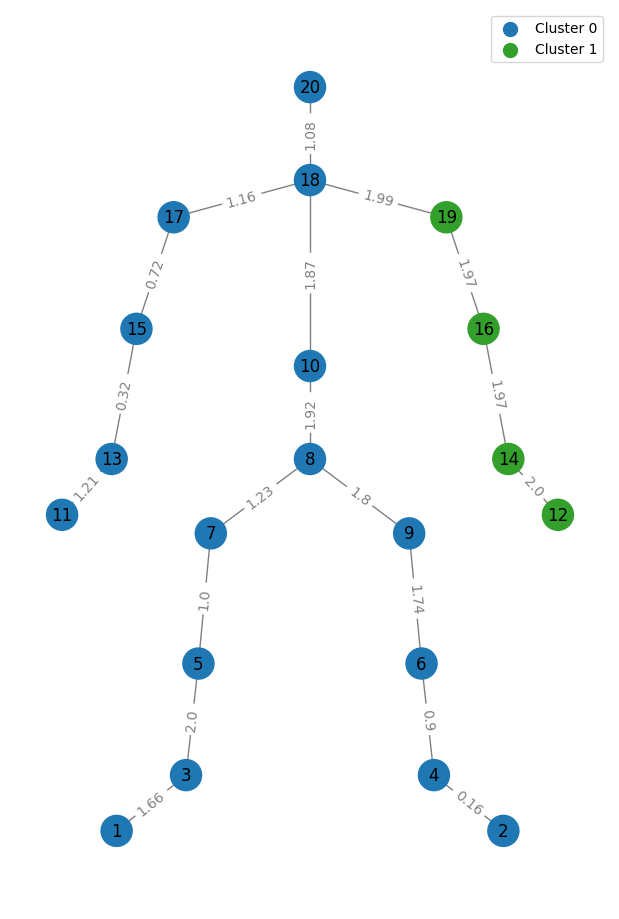

In [165]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
%matplotlib inline
import numpy as np

jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]

allNodes = set(jointsFrom).union(set(jointsTo))

jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))

if not 'cosineSimVelocity' in locals():
    import pandas as pd
    print("not runned above cells, starting from cached cosine similarity for acceleration")
    featuresTable = pd.read_csv("_cachedCosineSimAcceleration.csv")
else:
    featuresTable = cosineSimVelocity

featuresTableNormalized = featuresTable.div(featuresTable.max(axis=1),axis=0) * 2

timeInstant = 0
weights = np.array(featuresTableNormalized.iloc[timeInstant,:])

adj_matrix = np.zeros((len(allNodes),len(allNodes)))
for from_node, to_node, weight in zip(jointsFrom, jointsTo, weights):
    adj_matrix[to_node, from_node] = weight


## Compute the Laplacian Matrix
# We'll use the normalized Laplacian for this example.

# Compute the degree matrix (sum of the weights of each node's edges)
degree_matrix = np.diag(np.sum(adj_matrix, axis=1))

# Compute the Laplacian matrix
laplacian_matrix = degree_matrix - adj_matrix

## Compute Eigenvalues and Eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)

## Form a New Feature Representation
# We'll use the first k eigenvectors as our new feature representation.
# Choose the number of clusters (k) you want to identify.
k = 2
idx = np.argsort(eigenvalues)[0:k]
new_features = eigenvectors[:, idx]

## Clustering
# Use k-means clustering on the new feature representation
spectral_clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=3, assign_labels='kmeans')
predicted_labels = spectral_clustering.fit_predict(new_features)

# Create a graph using NetworkX from the adjacency matrix
graph = nx.from_numpy_array(adj_matrix, create_using=nx.Graph)

nodeMappings = {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())}
graph = nx.relabel_nodes(graph, nodeMappings)

# Get edge labels from adjacency matrix (if present)
edge_labels = nx.get_edge_attributes(graph, "weight")
# Clip edge weights to the 2nd decimal place
for edge, weight in edge_labels.items():
    edge_labels[edge] = round(weight, 2)

# You can also create an undirected graph by using create_using=nx.Graph

pos = map_pos_human_body_graph()
# Create the colormap
# Define a pool of colors for k classes (you can add more colors if needed)
color_pool = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#b15928']

# Use the color pool to map cluster labels to colors
node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

plt.figure(figsize=(6,9))
nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, edge_color="gray")
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=10, font_color='gray', label_pos=0.5)

# Create a custom legend for cluster labels
unique_labels = np.unique(predicted_labels)

# Create a custom legend for cluster labels using the color pool
legend_labels = {label: f"Cluster {label}" for label in unique_labels}
plt.legend(handles=[plt.scatter([], [], s=100, c=color, marker='o', label=legend_labels[label]) for label, color in zip(unique_labels, color_pool)], loc="upper right")

plt.show()

### Spectral Clustering

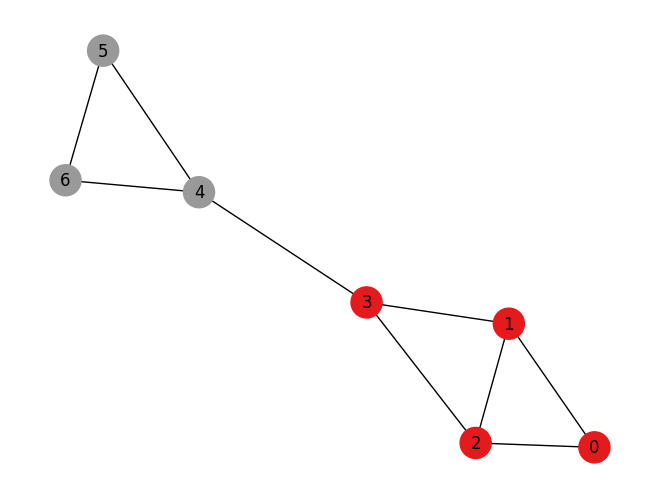

In [108]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Step 1: Build the Graph
# You can either create the graph manually or load it from your data source.
# For this example, let's create a simple graph.

# Define the edges of the graph (you can adjust these based on your data)
edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)]

# Create an undirected graph
G = nx.Graph()
G.add_edges_from(edges)

# Step 2: Construct the Affinity Matrix
# We'll use the adjacency matrix as the affinity matrix for this example.

# Get the adjacency matrix as a numpy array
adjacency_matrix = nx.to_numpy_array(G)

# Step 3: Compute the Laplacian Matrix
# We'll use the normalized Laplacian for this example.

# Compute the degree matrix (sum of the weights of each node's edges)
degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))

# Compute the Laplacian matrix
laplacian_matrix = degree_matrix - adjacency_matrix

# Step 4: Compute Eigenvalues and Eigenvectors
# Use numpy's linalg.eig function to compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)

# Step 5: Form a New Feature Representation
# We'll use the first k eigenvectors as our new feature representation.
# Choose the number of clusters (k) you want to identify.
k = 2
idx = np.argsort(eigenvalues)[0:k]
new_features = eigenvectors[:, idx]

# Step 6: Clustering
# Use k-means clustering on the new feature representation
spectral_clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=4, assign_labels='kmeans')
predicted_labels = spectral_clustering.fit_predict(new_features)

# Plot the graph with node colors based on the clustering result
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=predicted_labels, cmap=plt.cm.Set1, node_size=500)
plt.show()


## Shapley

### Reproducing second case in 'Vizialization_Shepley_with_spectral_clustering_GG.m'

In [78]:
shapleys = pd.DataFrame(columns=['firstMaxValue','firstIndex','secondMaxValue','secondIndex']).astype({ 'firstMaxValue': float,
                                                                                                        'firstIndex': int,
                                                                                                        'secondMaxValue': float,
                                                                                                        'secondIndex': int
                                                                                                    })
shapleys['firstMaxValue'] = cosineSimAccelerationNormalized.max(axis=1)
shapleys['firstIndex'] = [int(cosineSimAccelerationNormalized.columns.get_loc(row)) for row in cosineSimAccelerationNormalized.idxmax(axis=1)]

# set max values cells to -inf 
tableWithoutFirstMax = cosineSimAccelerationNormalized.copy()
for i,shap_row in shapleys.iterrows():
    tableWithoutFirstMax.iloc[i, int(shap_row['firstIndex'])] = float('-inf') 

shapleys['secondMaxValue'] = tableWithoutFirstMax.max(axis=1)
shapleys['secondIndex'] = [tableWithoutFirstMax.columns.get_loc(row) for row in tableWithoutFirstMax.idxmax(axis=1)]

print(shapleys)

     firstMaxValue  firstIndex  secondMaxValue  secondIndex
0              2.0          13        1.996316            1
1              2.0           1        1.997122           13
2              2.0          13        1.981765           17
3              2.0          13        1.988791           17
4              2.0          13        1.999259            9
..             ...         ...             ...          ...
572            2.0          17        1.997838           13
573            2.0          17        1.996498           13
574            2.0          17        1.995206           13
575            2.0          17        1.994868           13
576            2.0          17        1.994858           13

[577 rows x 4 columns]


### Reproducing third case

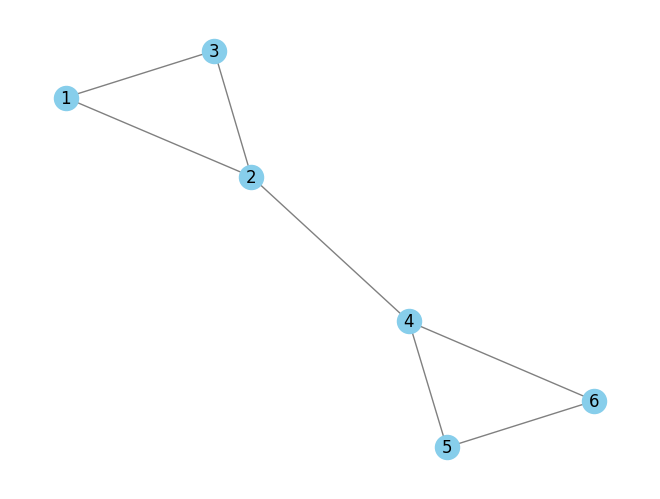

Nodes in the connected subgraph: [1, 2, 3, 4, 5, 6]
Edges in the connected subgraph: [(1, 2), (1, 3), (2, 3), (2, 4), (4, 5), (4, 6), (5, 6)]


In [85]:
import networkx as nx

# Create an example graph (replace this with your actual graph)
# For this example, we'll use an undirected graph
G = nx.Graph()
G.add_edges_from([(1, 2), (1, 3), (2, 3), (2, 4), (4, 5),(5,6),(6,4)])
nx.draw(G,with_labels=True,node_color="skyblue", edge_color="gray")
plt.show()

# Function to generate the connected subgraph from a given graph
def generate_connected_subgraph(graph, start_node):
    visited_nodes = set()
    queue = [start_node]
    while queue:
        node = queue.pop(0)
        if node not in visited_nodes:
            visited_nodes.add(node)
            neighbors = list(graph.neighbors(node))
            queue.extend(neighbors)
    subgraph_nodes = visited_nodes
    subgraph = graph.subgraph(subgraph_nodes)
    return subgraph

# Call the function with the start_node you want to begin the connected subgraph from
start_node = 1  # Replace this with the desired starting node
connected_subgraph = generate_connected_subgraph(G, start_node)

# Print the nodes and edges of the connected subgraph
print("Nodes in the connected subgraph:", connected_subgraph.nodes())
print("Edges in the connected subgraph:", connected_subgraph.edges())
